In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Intelligent Mobility Classifiers

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
from scipy.stats.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline
#import sys
#sys.path.append('/content/drive/MyDrive/MIDA2/')

In [3]:
base_path = "/content/drive/MyDrive/MIDA2/IntelligentMobilityProject/"
pictures_path = f"{base_path}Pictures/"
dataset_path = f"{base_path}Survey+dataset/"
results_path = f"{base_path}Code/Data/"

In [4]:
ds_path = '/content/drive/MyDrive/MIDA2/IntelligentMobilityProject/Survey+dataset/3_filtered_values.csv'

df = pd.read_csv(ds_path)

In [5]:
print("dataset size: ",len(df))
df.describe(include='all')

dataset size:  26605


,Country,Gender,Education,Profession,Work_status,Household_members,Income_level,Location_of_resudence,Centre_or_suburbs,Public_transport_service,Car_driving_license,Considering_electric_or_hybrid_vehicle_next_purchase,Know_what_car_sharing_is,Would_subsribe_car_sharing_if_available,Most_frequent_trip_Walk,Most_frequent_trip_Bicycle,Most_frequent_trip_Car_as_Driver,Most_frequent_trip_Car_as_Passenger,Most_frequent_trip_Train,Most_frequent_trip_Underground_or_light_train,Most_frequent_trip_Tram,Most_frequent_trip_Bus,Most_frequent_trip_Motorcycle_or_moped,Destination_most_frequent_trip,Frequency_most_frequent_trip,Frequent_trip_distance,Concern_environmental_impacts,Preference_tolls_or_traffic_limitation,grouped_Frequent_trip_duration_in_minutes,grouped_Region_3,InternetUsers,grouped_Number_vehicles_in_household,grouped_Age
count,26605,26605,26605,26605,26605,26605,26605,26605,26605,26605,26605,26605,26605,26605,26605,26605,26605,26605,26605,26605,26605,26605,26605,26605,26605,26605,26605,26605,26605,26605,26605.000000,26605,26605
unique,28,2,4,14,2,7,6,4,3,4,2,6,3,7,2,2,2,2,2,2,2,2,2,3,3,7,11,5,10,102,NaN,6,10
top,Hungary,Female,Upper secondary (high school or similar);,other employed worker,Employed,two,middle,Small or medium town (less than 250.000 inhabi...,in the suburbs,Well served by public transport,Yes,Maybe yes maybe not,No,"Maybe yes, maybe not. I would need to test the...",No,No,Yes,No,No,No,No,No,No,"…In an urban area, same as where I live",Make this trip every day/ every working day of...,6-10 KM,8,No preferences,30:31,HR0,NaN,1,47:51
freq,1020,13441,12585,5436,18649,7421,13555,11490,10669,11068,21684,8042,13333,11838,20340,22965,14675,22817,24862,25214,25293,21262,25875,11804,18359,5594,5831,9425,3884,1162,NaN,12003,3186
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.383612,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.097386,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.000000,NaN,NaN


In [6]:
target_variable = "Considering_electric_or_hybrid_vehicle_next_purchase"
input_variables = list(df.columns[df.columns!=target_variable])

train_df, test_df = train_test_split(df, test_size=0.2, random_state=1111)
print("train_len: ", len(train_df))
print("test_len: ", len(test_df))

train_len:  21284
test_len:  5321


In [7]:
df[target_variable].value_counts() / sum(df[target_variable].value_counts())

Maybe yes maybe not     0.302274
Probably yes            0.213644
Probably not            0.199662
Certainly yes           0.104529
Certainly not           0.099493
Don't know/no answer    0.080398
Name: Considering_electric_or_hybrid_vehicle_next_purchase, dtype: float64

# Encodings

In [8]:
def one_hot_encode(train_data, test_data, columns):
    conc = pd.concat([train_data, test_data], axis=0)
    encoded = pd.get_dummies(conc.loc[:, columns], drop_first=True,
                             sparse=True) 
    return (encoded.iloc[:train_data.shape[0],:], 
            encoded.iloc[train_data.shape[0]:,:])

def label_encode(train_data, test_data, columns):
    'Returns a DataFrame with encoded columns'
    encoded_cols = []
    for col in columns:
        factorised = pd.factorize(train_data[col])[1]
        labels = pd.Series(range(len(factorised)), index=factorised)
        encoded_col_train = train_data[col].map(labels) 
        encoded_col_test = test_data[col].map(labels)
        encoded_col = pd.concat([encoded_col_train, encoded_col_test], axis=0)
        encoded_col[encoded_col.isnull()] = -1
        encoded_cols.append(pd.DataFrame({'label_'+col:encoded_col}))
    all_encoded = pd.concat(encoded_cols, axis=1)
    return (all_encoded.loc[train_data.index,:], 
            all_encoded.loc[test_data.index,:])

def freq_encode(train_data, test_data, columns):
    '''Returns a DataFrame with encoded columns'''
    encoded_cols = []
    nsamples = train_data.shape[0]
    for col in columns:    
        freqs_cat = train_data.groupby(col)[col].count()/nsamples
        encoded_col_train = train_data[col].map(freqs_cat)
        encoded_col_test = test_data[col].map(freqs_cat)
        encoded_col = pd.concat([encoded_col_train, encoded_col_test], axis=0)
        encoded_col[encoded_col.isnull()] = 0
        encoded_cols.append(pd.DataFrame({'freq_'+col:encoded_col}))
    all_encoded = pd.concat(encoded_cols, axis=1)
    return (all_encoded.loc[train_data.index,:], 
            all_encoded.loc[test_data.index,:])
    
def encoding_stats(train_data, test_data, X_train, X_test, target_col, encoding_function, feature_cols_to_use):
    if encoding_function.__name__ == 'one_hot_encode':
        return np.nan, np.nan, np.nan, np.nan
    if encoding_function.__name__ == 'mean_encode':
        enc_suffix = 'mean_'+target_col+'_'
    if encoding_function.__name__ == 'freq_encode':    
        enc_suffix = 'freq_'
    if encoding_function.__name__ == 'label_encode':
        enc_suffix = 'label_'
    cols_to_encoded_mapping = {}
    for col in feature_cols_to_use:
        for col_enc in X_train.columns:
            if col == col_enc[len(enc_suffix):]:
                cols_to_encoded_mapping[col] = col_enc
    train_conc = pd.concat([train_data, X_train], axis=1)
    test_conc = pd.concat([test_data, X_test], axis=1)
    mean_stds_train = []
    std_means_train = []
    mean_stds_test = []
    std_means_test = []
    for key in cols_to_encoded_mapping.keys():
        #how much randomisation added
        mean_stds_train.append(train_conc.groupby(key)[cols_to_encoded_mapping[key]].std().mean())
        mean_stds_test.append(test_conc.groupby(key)[cols_to_encoded_mapping[key]].std().mean())
        # how distinguishable are categories with that encoding
        std_means_train.append(train_conc.groupby(key)[cols_to_encoded_mapping[key]].mean().std())
        std_means_test.append(test_conc.groupby(key)[cols_to_encoded_mapping[key]].mean().std())
    
    encoding_stats = (np.mean(mean_stds_train), np.mean(std_means_train),
                      np.mean(mean_stds_test), np.mean(std_means_test))
    return encoding_stats

def test_all_encodings(train_data, test_data, target_col, testing_params, 
                       test_one_hot=False, regression=False, skip_first_iters_graph=0,
                      max_features_one_hot=0.01):
    encoding_settings = [[label_encode, {}, 'Label encoding', '#960000'],
                         [freq_encode, {}, 'Frequency encoding', '#FF2F02'],
                         [mean_encode, {'alpha':0, 'folds':None, 'reg_method':None, 
                                        'add_random':False, 'rmean':0, 'rstd':0.0,
                                        'target_col':target_col},
                         'Mean encoding, alpha=0', '#A4C400'],
                         [mean_encode, {'alpha':2, 'folds':None, 'reg_method':None, 
                                        'add_random':False, 'rmean':0, 'rstd':0.0,
                                        'target_col':target_col}, 
                         'Mean encoding, alpha=2', '#73B100'],
                         [mean_encode, {'alpha':5, 'folds':None, 'reg_method':None, 
                                        'add_random':False, 'rmean':0, 'rstd':0.0,
                                        'target_col':target_col}, 
                         'Mean encoding, alpha=5', '#2B8E00'],
                         [mean_encode, {'alpha':5, 'folds':3, 'reg_method':'k_fold', 
                                        'add_random':False, 'rmean':0, 'rstd':0.0,
                                        'target_col':target_col}, 
                         'Mean encoding, alpha=5, 4 folds', '#00F5F2'],
                         [mean_encode, {'alpha':5, 'folds':5, 'reg_method':'k_fold', 
                                        'add_random':False, 'rmean':0, 'rstd':0.0,
                                        'target_col':target_col}, 
                         'Mean encoding, alpha=5, 7 folds', '#00BAD3'],
                         [mean_encode, {'alpha':5, 'folds':None, 'reg_method':'expanding_mean', 
                                        'add_random':False, 'rmean':0, 'rstd':0.0,
                                        'target_col':target_col}, 
                         'Mean encoding, alpha=5, expanding mean', '#B22BFA']]
    review_rows = []
    if test_one_hot:
        oh_settings = [[one_hot_encode, {}, 'One hot encoding', '#E7E005']]
        encoding_settings = oh_settings + encoding_settings
    feature_cols_to_use = list(train_data.columns)
    feature_cols_to_use.remove(target_col)
    if regression:
        scoring_function = scoring_gbr_sklern
        best_score_function = min
    else:
        scoring_function = scoring_gbc_sklern
        best_score_function = max     
    plt.figure(figsize=(10,7))
    for encoding_function, encoding_params, str_name, color in encoding_settings:
        if encoding_function.__name__ == 'one_hot_encode':
            testing_params['max_features'] = max_features_one_hot
        else:
            testing_params['max_features'] = None
        X_train, X_test = encoding_function(train_data, test_data, feature_cols_to_use,
                                            **encoding_params)
        scores = scoring_function(X_train, train_data[target_col], X_test, 
                                    test_data[target_col], 
                                    min_samples_leaf=1, max_depth=3, **testing_params)
        skip_it = int(skip_first_iters_graph)
        train_scores, test_scores, iters, model_ = scores
        plt.plot(iters[skip_it:], 
                 test_scores[skip_it:], 
                 label='Test, ' + str_name, linewidth=1.5, color=color)
        best_score_test = best_score_function(test_scores)
        best_iter_test = iters[test_scores.index(best_score_test)]
        best_score_train = best_score_function(train_scores[:best_iter_test])
        print('Best score for {}: is {}, on iteration {}'.format(str_name, 
                                                                 best_score_test, 
                                                                 best_iter_test,
                                                                 best_score_train))
        enc_stats = encoding_stats(train_data, test_data, X_train, X_test, 
                                   target_col, encoding_function, feature_cols_to_use)
        review_rows.append([str_name, best_score_train, best_score_test, best_iter_test] + list(enc_stats))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if regression:
        columns=['Encoding', 'Train RMSE score on best iteration', 
             'Best RMSE score (test)', 'Best iteration (test)',
             'EV (train)', 'ED (train)', 'EV (test)', 'ED (test)']
    else:
        columns=['Encoding', 'Train AUC score on best iteration', 
             'Best AUC score (test)', 'Best iteration (test)',
             'EV (train)', 'ED (train)', 'EV (test)', 'ED (test)']
    return pd.DataFrame(review_rows, columns=columns)

In [9]:
object_type = df["Country"].dtype

categorical_var = [var for var in df if df[var].dtype == object_type]
categorical_var.remove(target_variable)
categorical_var

['Country',
 'Gender',
 'Education',
 'Profession',
 'Work_status',
 'Household_members',
 'Income_level',
 'Location_of_resudence',
 'Centre_or_suburbs',
 'Public_transport_service',
 'Car_driving_license',
 'Know_what_car_sharing_is',
 'Would_subsribe_car_sharing_if_available',
 'Most_frequent_trip_Walk',
 'Most_frequent_trip_Bicycle',
 'Most_frequent_trip_Car_as_Driver',
 'Most_frequent_trip_Car_as_Passenger',
 'Most_frequent_trip_Train',
 'Most_frequent_trip_Underground_or_light_train',
 'Most_frequent_trip_Tram',
 'Most_frequent_trip_Bus',
 'Most_frequent_trip_Motorcycle_or_moped',
 'Destination_most_frequent_trip',
 'Frequency_most_frequent_trip',
 'Frequent_trip_distance',
 'Concern_environmental_impacts',
 'Preference_tolls_or_traffic_limitation',
 'grouped_Frequent_trip_duration_in_minutes',
 'grouped_Region_3',
 'grouped_Number_vehicles_in_household',
 'grouped_Age']

In [10]:
train, test = freq_encode(train_df, test_df, categorical_var)

In [11]:
for var in categorical_var:
  #train_df["freq_" + var] = train["freq_" + var]
  #test_df["freq_" + var] = test["freq_" + var]
  train_df[var] = train["freq_" + var]
  test_df[var] = test["freq_" + var]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [12]:
#train_df = train_df.drop(categorical_var, axis=1)
#test_df = test_df.drop(categorical_var, axis=1)

In [13]:
train_df.dtypes

Country                                                 float64
Gender                                                  float64
Education                                               float64
Profession                                              float64
Work_status                                             float64
Household_members                                       float64
Income_level                                            float64
Location_of_resudence                                   float64
Centre_or_suburbs                                       float64
Public_transport_service                                float64
Car_driving_license                                     float64
Considering_electric_or_hybrid_vehicle_next_purchase     object
Know_what_car_sharing_is                                float64
Would_subsribe_car_sharing_if_available                 float64
Most_frequent_trip_Walk                                 float64
Most_frequent_trip_Bicycle              

In [14]:
X_train = train_df[input_variables].values
y_train = train_df[target_variable].values

X_test = test_df[input_variables].values
y_test = test_df[target_variable].values

In [15]:
train_df.dtypes

Country                                                 float64
Gender                                                  float64
Education                                               float64
Profession                                              float64
Work_status                                             float64
Household_members                                       float64
Income_level                                            float64
Location_of_resudence                                   float64
Centre_or_suburbs                                       float64
Public_transport_service                                float64
Car_driving_license                                     float64
Considering_electric_or_hybrid_vehicle_next_purchase     object
Know_what_car_sharing_is                                float64
Would_subsribe_car_sharing_if_available                 float64
Most_frequent_trip_Walk                                 float64
Most_frequent_trip_Bicycle              

In [16]:
models = {'Gradient Boost':GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=2, random_state=0)}

In [17]:
random_seed=1111

In [18]:
#scores = {}
#for model_name in models:
#    clf = models[model_name];
#    #score = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=10,shuffle=True,random_state=random_seed))
#    
#    scores[model_name]=(np.average(score),np.std(score))
#    print('%26s %3.1f %3.1f'%(model_name,100.0*np.average(score),100.0*np.std(score)))

In [19]:
clf = models["Gradient Boost"]
clf.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=1.0, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [20]:
X_train

array([[3.85735764e-02, 5.05074234e-01, 4.72373614e-01, ...,
        8.50000000e+01, 3.04313099e-01, 1.02283405e-01],
       [3.69761323e-02, 5.05074234e-01, 3.70278143e-01, ...,
        8.70000000e+01, 1.25540312e-01, 9.76320241e-02],
       [3.72110506e-02, 5.05074234e-01, 3.70278143e-01, ...,
        4.20000000e+01, 3.04313099e-01, 8.96448036e-02],
       ...,
       [3.75869198e-02, 4.94925766e-01, 3.70278143e-01, ...,
        6.10000000e+01, 3.04313099e-01, 9.07254276e-02],
       [3.85265927e-02, 4.94925766e-01, 3.70278143e-01, ...,
        6.10000000e+01, 3.04313099e-01, 9.89005826e-02],
       [3.84796091e-02, 5.05074234e-01, 3.70278143e-01, ...,
        8.40000000e+01, 1.25540312e-01, 1.05478294e-01]])

In [21]:
clf.score(X_test, y_test)

0.3416651005450103

In [22]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [23]:
clf.predict_proba(X_train)[:, 1]

array([0.02906457, 0.04054446, 0.0420863 , ..., 0.10032182, 0.1033812 ,
       0.21006966])

In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_train, clf.predict(X_train)))

                      precision    recall  f1-score   support

       Certainly not       0.41      0.24      0.31      2127
       Certainly yes       0.46      0.21      0.29      2216
Don't know/no answer       0.48      0.38      0.42      1724
 Maybe yes maybe not       0.41      0.61      0.49      6406
        Probably not       0.41      0.35      0.38      4306
        Probably yes       0.42      0.42      0.42      4505

            accuracy                           0.42     21284
           macro avg       0.43      0.37      0.38     21284
        weighted avg       0.42      0.42      0.41     21284



In [25]:
print(classification_report(y_test, clf.predict(X_test)))

                      precision    recall  f1-score   support

       Certainly not       0.28      0.17      0.21       520
       Certainly yes       0.31      0.15      0.20       565
Don't know/no answer       0.36      0.30      0.33       415
 Maybe yes maybe not       0.37      0.53      0.43      1636
        Probably not       0.29      0.27      0.28      1006
        Probably yes       0.35      0.32      0.34      1179

            accuracy                           0.34      5321
           macro avg       0.33      0.29      0.30      5321
        weighted avg       0.33      0.34      0.33      5321



In [26]:
importances = clf.feature_importances_

In [27]:
from sklearn.inspection import permutation_importance
import time

start_time = time.time()
result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")



Elapsed time to compute the importances: 15.033 seconds


In [28]:
result.importances_std

array([0.00251271, 0.00181325, 0.00135065, 0.00164365, 0.00131299,
       0.00172869, 0.00281425, 0.00174445, 0.00221444, 0.00198571,
       0.00166022, 0.00244199, 0.00446751, 0.0012152 , 0.00132144,
       0.00147322, 0.00104991, 0.00087848, 0.00072202, 0.00057895,
       0.00129402, 0.00073487, 0.00091704, 0.00185247, 0.00110291,
       0.00415569, 0.00380557, 0.00266317, 0.00267772, 0.00474657,
       0.00276136, 0.00320394])

In [29]:
forest_importances = pd.Series(result.importances_mean, index=input_variables)
forest_importances_sorted = forest_importances.sort_values(ascending=False)
#forest_importances_sorted

In [30]:
forest_importances_sorted[:15]

Would_subsribe_car_sharing_if_available          0.023661
Country                                          0.020447
Concern_environmental_impacts                    0.013306
grouped_Region_3                                 0.008513
InternetUsers                                    0.007536
Preference_tolls_or_traffic_limitation           0.004774
Frequent_trip_distance                           0.002706
Car_driving_license                              0.002368
Most_frequent_trip_Tram                          0.002274
Most_frequent_trip_Underground_or_light_train    0.001165
Location_of_resudence                            0.001165
Most_frequent_trip_Bicycle                       0.000864
grouped_Age                                      0.000827
Most_frequent_trip_Motorcycle_or_moped           0.000733
Education                                        0.000658
dtype: float64

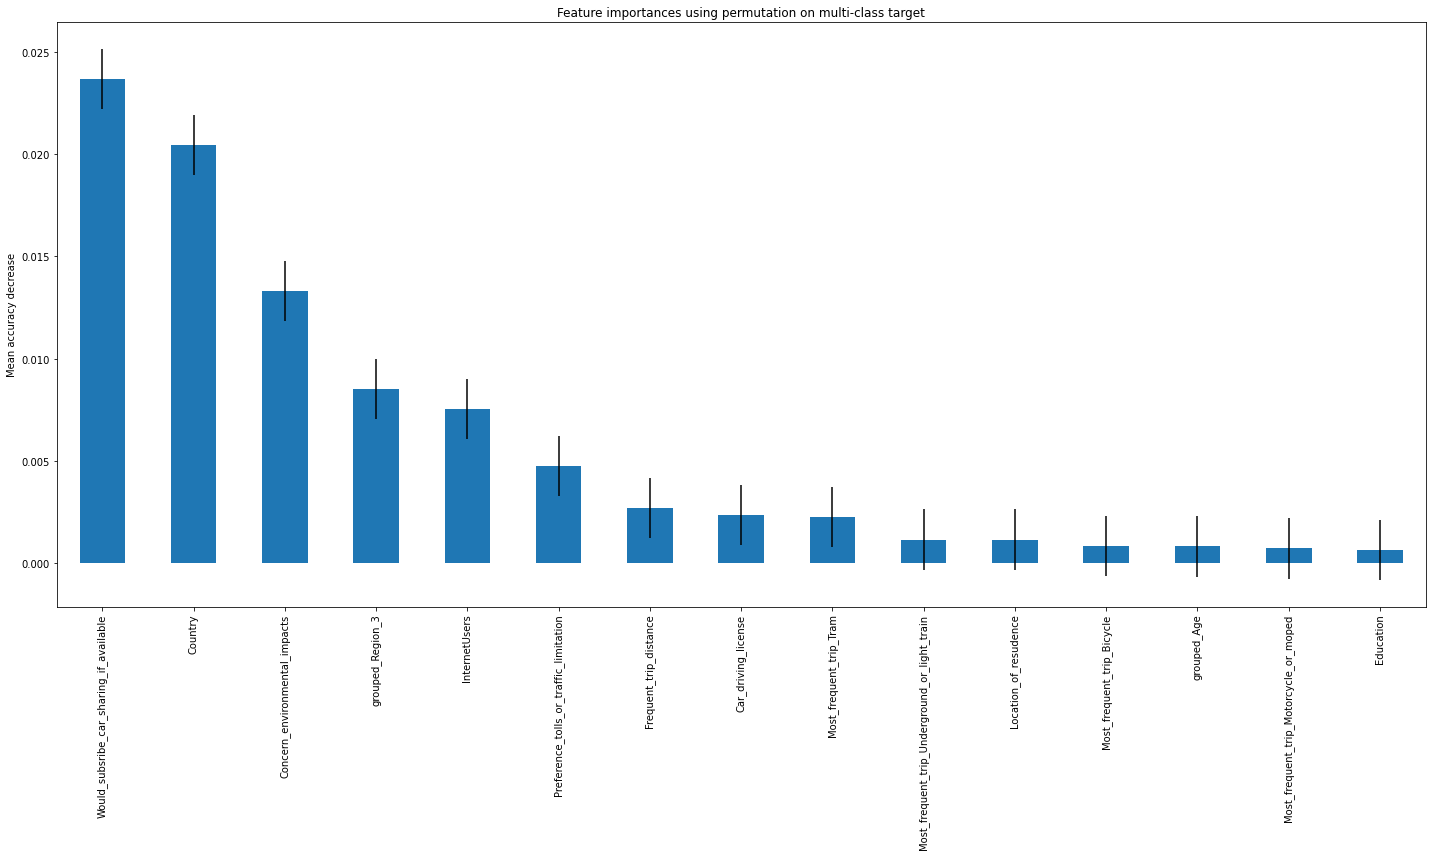

In [31]:
fig, ax = plt.subplots(figsize=(20,12))
topFeatures = 15
forest_importances_sorted[:topFeatures].plot.bar(yerr=result.importances_std[topFeatures], ax=ax)
ax.set_title("Feature importances using permutation on multi-class target")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
filename = "feature_importance_original_target.png"
save_path = f"{pictures_path}Classification/FeatureImportances/{filename}"
plt.savefig(save_path)
plt.show()

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
answer_order = ["Certainly not", "Probably not", "Maybe yes maybe not", "Don't know/no answer", "Probably yes", "Certainly yes"]

In [34]:
cm = confusion_matrix(y_test, clf.predict(X_test), labels=answer_order)
df_cm = pd.DataFrame(cm, index = answer_order,
                  columns = answer_order)

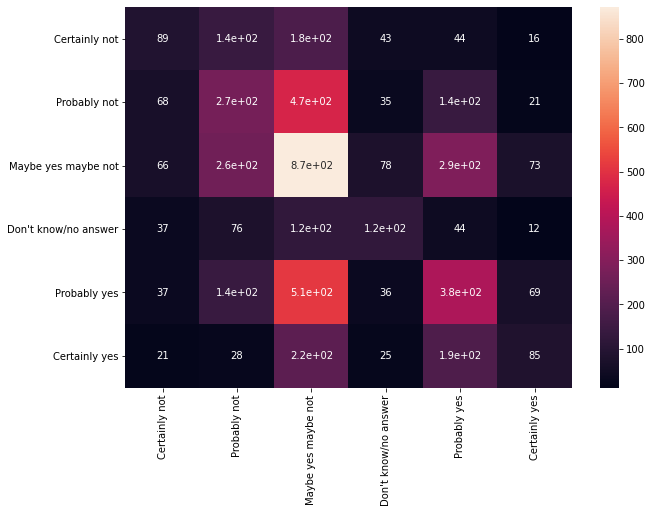

In [35]:
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

@Andre

In [36]:
test_df[target_variable].value_counts() / sum(test_df[target_variable].value_counts())

Maybe yes maybe not     0.307461
Probably yes            0.221575
Probably not            0.189062
Certainly yes           0.106183
Certainly not           0.097726
Don't know/no answer    0.077993
Name: Considering_electric_or_hybrid_vehicle_next_purchase, dtype: float64

In [37]:
train_df[target_variable].value_counts() 

Maybe yes maybe not     6406
Probably yes            4505
Probably not            4306
Certainly yes           2216
Certainly not           2127
Don't know/no answer    1724
Name: Considering_electric_or_hybrid_vehicle_next_purchase, dtype: int64

In [38]:
df[target_variable].value_counts() / sum(df[target_variable].value_counts())

Maybe yes maybe not     0.302274
Probably yes            0.213644
Probably not            0.199662
Certainly yes           0.104529
Certainly not           0.099493
Don't know/no answer    0.080398
Name: Considering_electric_or_hybrid_vehicle_next_purchase, dtype: float64

it mantains distribution of answers from source dataset

## Trying with only 2 labels

In [39]:
df[target_variable].unique()

array(['Maybe yes maybe not', 'Probably not', 'Certainly not',
       'Probably yes', "Don't know/no answer", 'Certainly yes'],
      dtype=object)

In [40]:
df_2 = df[df[target_variable] != 'Maybe yes maybe not']
df_2 = df_2[df_2[target_variable] != "Don't know/no answer"]
df_2

,Country,Gender,Education,Profession,Work_status,Household_members,Income_level,Location_of_resudence,Centre_or_suburbs,Public_transport_service,Car_driving_license,Considering_electric_or_hybrid_vehicle_next_purchase,Know_what_car_sharing_is,Would_subsribe_car_sharing_if_available,Most_frequent_trip_Walk,Most_frequent_trip_Bicycle,Most_frequent_trip_Car_as_Driver,Most_frequent_trip_Car_as_Passenger,Most_frequent_trip_Train,Most_frequent_trip_Underground_or_light_train,Most_frequent_trip_Tram,Most_frequent_trip_Bus,Most_frequent_trip_Motorcycle_or_moped,Destination_most_frequent_trip,Frequency_most_frequent_trip,Frequent_trip_distance,Concern_environmental_impacts,Preference_tolls_or_traffic_limitation,grouped_Frequent_trip_duration_in_minutes,grouped_Region_3,InternetUsers,grouped_Number_vehicles_in_household,grouped_Age
1,France,Male,"Tertiary and higher (University degree, PhD or...",unemployed,Not Employed,four,low,Small or medium town (less than 250.000 inhabi...,in the centre of the city,Difficult to reach with public transport,Yes,Probably not,Yes,"Maybe yes, maybe not. I would need to test the...",No,No,Yes,No,No,No,No,No,No,"…In an urban area, different from where I live",Make this trip 2-3 days per week,11-20 KM,8,Probably more acceptable to limit road traffic,20:21,FRG,71,3,23:27
2,Czech Republic,Male,"Tertiary and higher (University degree, PhD or...",other employed worker,Employed,four,middle,Large city (from 250.000 to 1.000.000 inhabita...,in the suburbs,Well served by public transport,Yes,Certainly not,Yes,"No, I would not be interested in this service",Yes,Yes,Yes,No,No,No,No,No,No,"…In an urban area, same as where I live",Make this trip every day/ every working day of...,less than 3 KM,6,No preferences,20:21,CZ0,63,1,47:51
4,Poland,Male,Upper secondary (high school or similar);,manual worker/agricultural worker/farmer,Employed,four,higher middle,Metropolitan area of a big city with more than...,in the suburbs,Well served by public transport,No,Probably yes,No,"Maybe yes, maybe not. I would need to test the...",No,No,No,No,No,No,No,No,Yes,"…In an urban area, same as where I live",Make this trip every day/ every working day of...,11-20 KM,8,No preferences,30:31,PL6,50,1,35:39
6,Hungary,Male,Upper secondary (high school or similar);,registered freelance professional,Employed,four,middle,Small or medium town (less than 250.000 inhabi...,in the suburbs,Difficult to reach with public transport,Yes,Probably yes,No,Yes without any influence on my car ownership,No,No,Yes,No,No,No,No,No,No,…It is outside an urban area,Make this trip every day/ every working day of...,more than 50 KM,5,Probably more acceptable to limit road traffic,60:75,HU3,57,2,47:51
7,Sweden,Female,"Tertiary and higher (University degree, PhD or...",teacher/lecturer,Employed,three,higher middle,Small or medium town (less than 250.000 inhabi...,in the centre of the city,Difficult to reach with public transport,Yes,Certainly yes,Yes,"Yes, instead of purchasing a new car",No,Yes,No,No,No,No,No,No,No,"…In an urban area, same as where I live",Make this trip every day/ every working day of...,less than 3 KM,10,Definitely more acceptable to pay for less con...,0:10,SE2,81,1,39:43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26595,Cyprus,Female,"Tertiary and higher (University degree, PhD or...",middle manager,Employed,two,middle,Large city (from 250.000 to 1.000.000 inhabita...,in the suburbs,Relatively served by public transport,Yes,Probably not,No,"Maybe yes, maybe not. I would need to test the...",No,No,No,Yes,No,No,No,No,No,"…In an urban area, same as where I live",Make this trip every day/ every working day of...,3-5 KM,4,Probably more acceptable to limit road traffic,10:15,CY,63,1,43:47
26597,Cyprus,Male,"Tertiary and higher (University degree, PhD or...",middle manager,Employed,more than five,higher middle,Large city (from 250.000 to 1.000.000 inhabita...,in th

In [41]:
df_2[target_variable].value_counts()

Probably yes     5684
Probably not     5312
Certainly yes    2781
Certainly not    2647
Name: Considering_electric_or_hybrid_vehicle_next_purchase, dtype: int64

In [42]:
target_map = {
    "Probably yes": "YES",
    "Certainly yes": "YES",
    "Probably not": "NO",
    "Certainly not": "NO",
}
df_2_fin = df_2.copy()
df_2_fin[target_variable] = df_2[target_variable].replace(target_map)

In [43]:
df_2_fin[target_variable].value_counts() / sum(df_2_fin[target_variable].value_counts())

YES    0.515404
NO     0.484596
Name: Considering_electric_or_hybrid_vehicle_next_purchase, dtype: float64

In [44]:
df_2_fin.to_csv('/content/drive/MyDrive/MIDA2/IntelligentMobilityProject/Survey+dataset/3_target_yes_no.csv', index=False)

In [45]:
df = df_2_fin
train_df, test_df = train_test_split(df, test_size=0.2, random_state=1111)
print("train_len: ", len(train_df))
print("test_len: ", len(test_df))

train_len:  13139
test_len:  3285


In [46]:
object_type = df["Country"].dtype

categorical_var = [var for var in df if df[var].dtype == object_type]
categorical_var.remove(target_variable)
categorical_var

['Country',
 'Gender',
 'Education',
 'Profession',
 'Work_status',
 'Household_members',
 'Income_level',
 'Location_of_resudence',
 'Centre_or_suburbs',
 'Public_transport_service',
 'Car_driving_license',
 'Know_what_car_sharing_is',
 'Would_subsribe_car_sharing_if_available',
 'Most_frequent_trip_Walk',
 'Most_frequent_trip_Bicycle',
 'Most_frequent_trip_Car_as_Driver',
 'Most_frequent_trip_Car_as_Passenger',
 'Most_frequent_trip_Train',
 'Most_frequent_trip_Underground_or_light_train',
 'Most_frequent_trip_Tram',
 'Most_frequent_trip_Bus',
 'Most_frequent_trip_Motorcycle_or_moped',
 'Destination_most_frequent_trip',
 'Frequency_most_frequent_trip',
 'Frequent_trip_distance',
 'Concern_environmental_impacts',
 'Preference_tolls_or_traffic_limitation',
 'grouped_Frequent_trip_duration_in_minutes',
 'grouped_Region_3',
 'grouped_Number_vehicles_in_household',
 'grouped_Age']

In [47]:
train, test = freq_encode(train_df, test_df, categorical_var)

In [48]:
for var in categorical_var:
  #train_df["freq_" + var] = train["freq_" + var]
  #test_df["freq_" + var] = test["freq_" + var]
  train_df[var] = train["freq_" + var]
  test_df[var] = test["freq_" + var]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [49]:
#train_df = train_df.drop(categorical_var, axis=1)
#test_df = test_df.drop(categorical_var, axis=1)

In [50]:
train_df.dtypes

Country                                                 float64
Gender                                                  float64
Education                                               float64
Profession                                              float64
Work_status                                             float64
Household_members                                       float64
Income_level                                            float64
Location_of_resudence                                   float64
Centre_or_suburbs                                       float64
Public_transport_service                                float64
Car_driving_license                                     float64
Considering_electric_or_hybrid_vehicle_next_purchase     object
Know_what_car_sharing_is                                float64
Would_subsribe_car_sharing_if_available                 float64
Most_frequent_trip_Walk                                 float64
Most_frequent_trip_Bicycle              

In [51]:
X_train = train_df[input_variables].values
y_train = train_df[target_variable].values

X_test = test_df[input_variables].values
y_test = test_df[target_variable].values

In [52]:
train_df.dtypes

Country                                                 float64
Gender                                                  float64
Education                                               float64
Profession                                              float64
Work_status                                             float64
Household_members                                       float64
Income_level                                            float64
Location_of_resudence                                   float64
Centre_or_suburbs                                       float64
Public_transport_service                                float64
Car_driving_license                                     float64
Considering_electric_or_hybrid_vehicle_next_purchase     object
Know_what_car_sharing_is                                float64
Would_subsribe_car_sharing_if_available                 float64
Most_frequent_trip_Walk                                 float64
Most_frequent_trip_Bicycle              

In [53]:
models = {'Gradient Boost':GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=2, random_state=0)}

In [54]:
random_seed=1111

In [55]:

#scores = {}
#for model_name in models:
#    clf = models[model_name];
#    #score = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=10,shuffle=True,random_state=random_seed))
#    
#    scores[model_name]=(np.average(score),np.std(score))
#    print('%26s %3.1f %3.1f'%(model_name,100.0*np.average(score),100.0*np.std(score)))

In [56]:
clf = models["Gradient Boost"]
clf.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=1.0, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [57]:
X_train

array([[4.33822970e-02, 4.82000152e-01, 4.69289900e-01, ...,
        5.60000000e+01, 4.50567014e-01, 1.04498059e-01],
       [4.71116523e-02, 4.82000152e-01, 4.69289900e-01, ...,
        6.40000000e+01, 3.07024888e-01, 8.95806378e-02],
       [4.01095974e-02, 5.17999848e-01, 3.80622574e-01, ...,
        7.70000000e+01, 1.17284420e-01, 1.15001142e-01],
       ...,
       [3.69130071e-02, 5.17999848e-01, 3.80622574e-01, ...,
        5.60000000e+01, 3.07024888e-01, 8.95806378e-02],
       [4.30017505e-02, 4.82000152e-01, 3.80622574e-01, ...,
        7.60000000e+01, 4.50567014e-01, 1.15001142e-01],
       [4.06423624e-02, 5.17999848e-01, 1.21470432e-01, ...,
        5.70000000e+01, 4.50567014e-01, 9.99315016e-02]])

In [58]:
clf.score(X_test, y_test)

0.7019786910197869

In [59]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [60]:
clf.predict_proba(X_train)

array([[0.71352267, 0.28647733],
       [0.67004958, 0.32995042],
       [0.31075696, 0.68924304],
       ...,
       [0.43586731, 0.56413269],
       [0.14792726, 0.85207274],
       [0.3279141 , 0.6720859 ]])

In [61]:
print(classification_report(y_train, clf.predict(X_train)))

              precision    recall  f1-score   support

          NO       0.73      0.72      0.73      6380
         YES       0.74      0.75      0.75      6759

    accuracy                           0.74     13139
   macro avg       0.74      0.74      0.74     13139
weighted avg       0.74      0.74      0.74     13139



In [62]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

          NO       0.70      0.68      0.69      1579
         YES       0.71      0.73      0.72      1706

    accuracy                           0.70      3285
   macro avg       0.70      0.70      0.70      3285
weighted avg       0.70      0.70      0.70      3285



In [63]:
importances = clf.feature_importances_

In [64]:
from sklearn.inspection import permutation_importance
import time

start_time = time.time()
result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 3.552 seconds


In [65]:
result.importances_std

array([0.0059123 , 0.00262732, 0.00315535, 0.00228392, 0.        ,
       0.00225431, 0.00215597, 0.00237287, 0.00144845, 0.00136952,
       0.0012555 , 0.00148384, 0.00439465, 0.        , 0.00164384,
       0.00113738, 0.00086958, 0.0013001 , 0.        , 0.00085073,
       0.00129008, 0.00064144, 0.00159955, 0.00103858, 0.00181222,
       0.00573309, 0.00234241, 0.00170173, 0.00378858, 0.00390897,
       0.00170581, 0.00260465])

In [66]:
forest_importances = pd.Series(result.importances_mean, index=input_variables)
forest_importances_sorted = forest_importances.sort_values(ascending=False)
#forest_importances_sorted

In [67]:
forest_importances_sorted[:10]

Would_subsribe_car_sharing_if_available    0.042222
grouped_Region_3                           0.041370
Concern_environmental_impacts              0.035890
Country                                    0.025358
InternetUsers                              0.017626
Gender                                     0.008250
Preference_tolls_or_traffic_limitation     0.006484
Location_of_resudence                      0.004932
grouped_Number_vehicles_in_household       0.004262
Frequent_trip_distance                     0.002618
dtype: float64

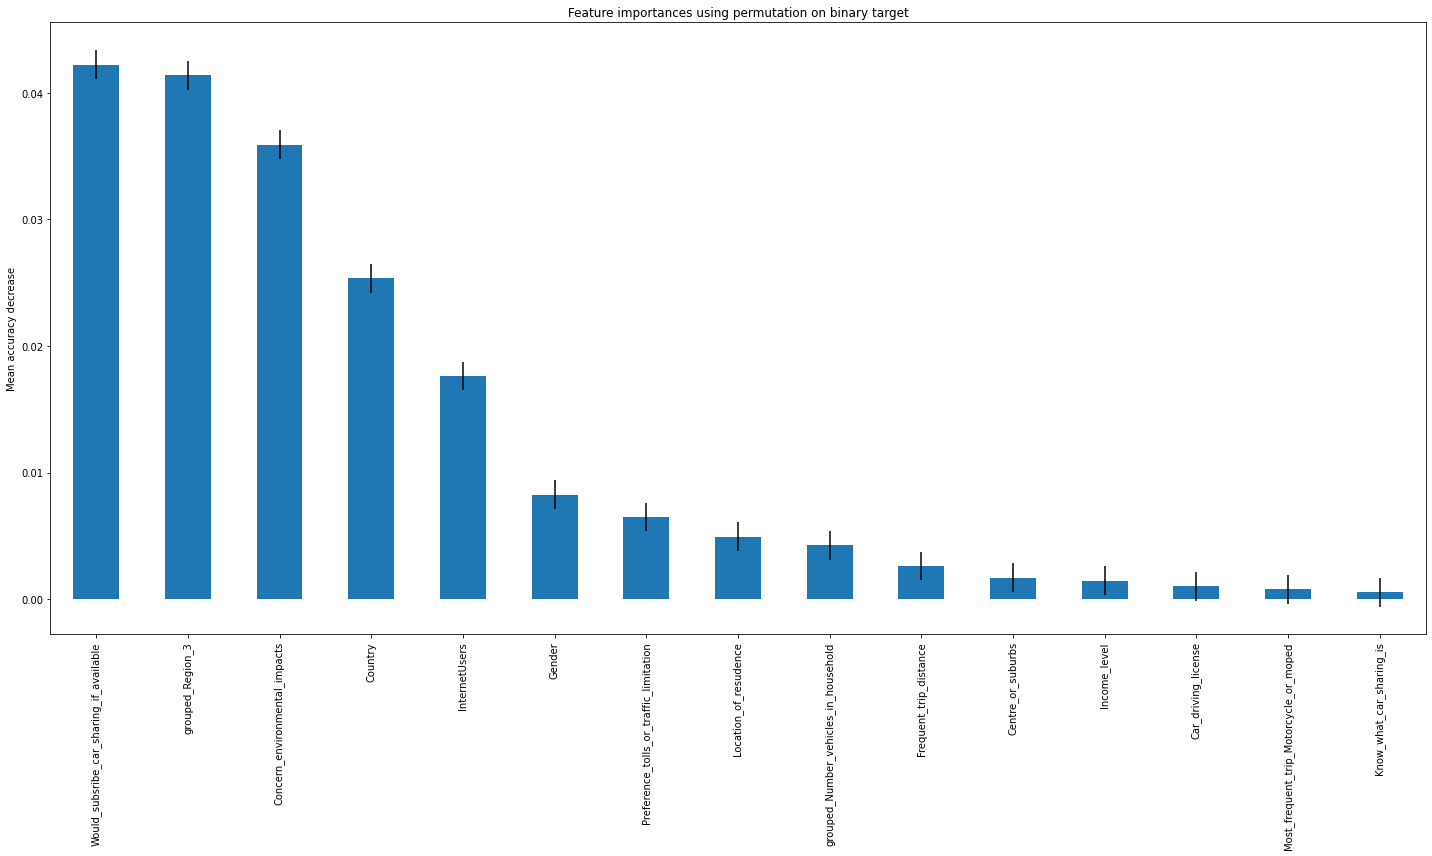

In [68]:
fig, ax = plt.subplots(figsize=(20,12))
forest_importances_sorted[:topFeatures].plot.bar(yerr=result.importances_std[topFeatures], ax=ax)
ax.set_title("Feature importances using permutation on binary target")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
filename = "feature_importance_binary_target.png"
save_path = f"{pictures_path}Classification/FeatureImportances/{filename}"
plt.savefig(save_path)
plt.show()

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [70]:
answer_order = ["NO", "YES"]

In [71]:
cm = confusion_matrix(y_test, clf.predict(X_test), labels=answer_order)
df_cm = pd.DataFrame(cm, index = answer_order,
                  columns = answer_order)

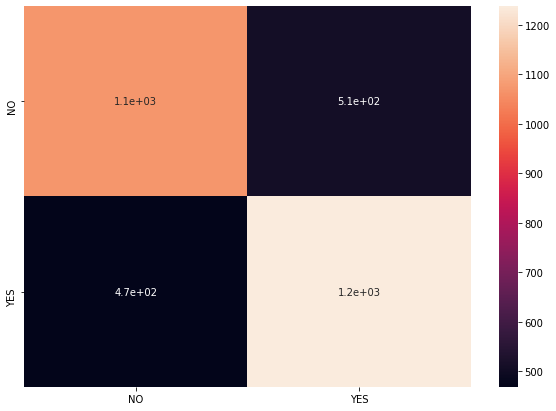

In [72]:
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)